# Cargar y explorar los datos:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

# If necessary, install required packages (use pip in the terminal)
# pip install matplotlib scikit-learn pandas
# pip install pandas-profiling

# 2. Cargar el dataset
df_train = pd.read_csv('./dataset/train.csv')  # Change this to the correct local path
df_test = pd.read_csv('./dataset/test.csv')


In [1]:
#log into wandb
import wandb
wandb.init(
    project="OBL-MACHINE-LEARNING-2024",
    name="DecTree#1"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sv267108 (sv267108-universidad-ort-uruguay). Use `wandb login --relogin` to force relogin


In [4]:
# Resumen de la información del dataframe
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11030 entries, 0 to 11029
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 11030 non-null  int64  
 1   Game Title         11030 non-null  object 
 2   Year               11014 non-null  float64
 3   Publisher          9992 non-null   object 
 4   North America      11030 non-null  float64
 5   Europe             11030 non-null  float64
 6   Japan              11030 non-null  float64
 7   Rest of World      11030 non-null  float64
 8   Global             11030 non-null  float64
 9   Number of Reviews  11030 non-null  object 
 10  Summary            1098 non-null   object 
 11  Wishlist           11030 non-null  object 
 12  Platform           11030 non-null  object 
 13  Genre              11030 non-null  object 
 14  Rating             11030 non-null  float64
dtypes: float64(7), int64(1), object(7)
memory usage: 1.3+ MB


,id,Game Title,Year,Publisher,North America,Europe,Japan,Rest of World,Global,Number of Reviews,Summary,Wishlist,Platform,Genre,Rating
0,1,Bloodstained: Curse of the Moon,2007.0,NaN,0.08,0.02,0.00,0.01,0.17,341.0,“Bloodstained: Curse of the Moon” is packed wi...,397.0,2600,Platform,7.345609
1,2,Plants vs. Zombies,2007.0,NaN,0.08,0.02,0.00,0.01,0.17,719.0,"Zombies are invading your home, and the only d...",82.0,2600,Puzzle,6.511195
2,3,Zero Escape: Zero Time Dilemma,2007.0,NaN,0.08,0.02,0.00,0.01,0.17,350.0,Zero Time Dilemma is the third and final entry...,402.0,2600,Puzzle,6.651093
3,4,Zelda II: The Adventure of Link,1987.0,Nintendo,2.19,0.50,1.61,0.08,4.38,756.0,Zelda II: The Adventure of Link is the second ...,290.0,NES,Adventure,7.900000
4,5,Yume Nikki,2007.0,NaN,0.08,0.02,0.00,0.01,0.17,770.0,Yume Nikki is a 32-Bit freeware game created b...,771.0,2600,Adventure,7.152074


In [5]:
missing_values = df_train.isnull().sum()
print(missing_values)


id                      0
Game Title              0
Year                   16
Publisher            1038
North America           0
Europe                  0
Japan                   0
Rest of World           0
Global                  0
Number of Reviews       0
Summary              9932
Wishlist                0
Platform                0
Genre                   0
Rating                  0
dtype: int64


# Rellenar valores faltantes:
En Publisher, rellenamos con una categoría como "Unknown" si no es crucial.
Para Summary, la eliminamos ya que no es relevante para la clasificación o utilizar técnicas de procesamiento de texto si planeas incluirla.

In [7]:
# Rellenar valores faltantes
def clean_data(df):
    # Fill missing 'Year' values with the median of the column
    df['Year'] = df['Year'].fillna(df['Year'].median())
    
    # Fill missing 'Publisher' values with 'Unknown'
    df['Publisher'] = df['Publisher'].fillna('Unknown')
    
    # Drop the 'Summary' column if it exists
    if 'Summary' in df.columns:
        df = df.drop(columns=['Summary'])
    
    # Check and return remaining missing values
    missing_values = df.isnull().sum()
    
    # Print missing values
    print("Missing values after cleaning:")
    print(missing_values)



    
    return df


# Convertir variables categóricas:

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def preprocess_data(df, is_train=True):    
    # Limpiar los datos
    df = clean_data(df)
    
    # Función auxiliar para convertir cadenas con 'K' a valores numéricos
    def convert_to_numeric(value):
        value_str = str(value)
        if 'K' in value_str:
            return int(float(value_str.replace('K', '')) * 1000)
        else:
            return int(float(value_str))
    
    # Aplicar la conversión a columnas numéricas
    columns_to_convert = [
        'Europe', 'Japan', 'Rest of World', 'North America', 
        'Global', 'Number of Reviews', 'Wishlist'
    ]
    for column in columns_to_convert:
        if column in df.columns:
            df[column] = df[column].apply(convert_to_numeric)
    
    # Codificación de variables categóricas
    label_encoder = LabelEncoder()
    categorical_columns = ['Game Title', 'Publisher', 'Platform', 'Genre']
    for column in categorical_columns:
        if column in df.columns:
            df[column] = label_encoder.fit_transform(df[column])
    
    # Separar características y objetivo en el conjunto de entrenamiento
    if is_train:
        # Si es el conjunto de entrenamiento, devolver características y objetivo
        X = df.drop(columns=['id', 'Rating'], errors='ignore')
        y = df['Rating'] if 'Rating' in df.columns else None
        return X, y
    else:
        # Si es el conjunto de prueba, eliminar 'id' y 'Rating' y devolver solo características
        X = df.drop(columns=['id', 'Rating'], errors='ignore')
        return X

# Ejemplo de uso:
# X_train, y_train = preprocess_data(df_train, is_train=True)
# X_test = preprocess_data(df_test, is_train=False)


# Separar características y objetivo

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
import numpy as np

def find_best_depth(X, Y, test_size=0.33, max_depth=20, cv=5, random_state=42):
    """
    Finds the best max_depth for a DecisionTreeRegressor using cross-validation.
    
    Parameters:
    - X (pd.DataFrame): Features.
    - Y (pd.Series): Target variable.
    - test_size (float): Proportion of data to use as the test set.
    - max_depth (int): Maximum depth to evaluate.
    - cv (int): Number of cross-validation folds.
    - random_state (int): Random seed for reproducibility.
    
    Returns:
    - best_depth (int): The depth that gives the lowest average MSE.
    - best_score (float): The corresponding mean squared error for the best depth.
    """
    
    # Split data into training and testing sets
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    # Define range of depths to evaluate
    depth_range = range(1, max_depth + 1)
    mean_scores = []
    
    # Perform cross-validation for each depth
    for depth in depth_range:
        model = DecisionTreeRegressor(max_depth=depth, criterion='squared_error', random_state=random_state)
        scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
        mean_scores.append(np.mean(np.abs(scores)))  # Store the mean absolute error
    
    # Determine the best depth based on mean score
    best_depth = depth_range[np.argmin(mean_scores)]
    best_score = min(mean_scores)
    
    print(f"Best depth: {best_depth}")
    print(f"Average Mean Squared Error with cross-validation: {best_score:.4f}")
    
    return best_depth, best_score




# Hacer arbol y evaluarlo:

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split


def train_and_evaluate_decision_tree(X, Y, best_depth, test_size=0.33, random_state=42):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    model = DecisionTreeRegressor(max_depth=best_depth, criterion='squared_error', random_state=random_state)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    print(f"Mean Squared Error (MSE) on test set: {mse:.4f}")
    
    # Plot the decision tree
    plt.figure(figsize=(15, 10))
    tree.plot_tree(model, filled=True, feature_names=X.columns, fontsize=10)
    plt.title(f"Decision Tree (Depth = {best_depth})")
    plt.show()
    
    return model, mse





Correr todas las funciones

In [11]:
def run_decision_tree_workflow(df_train, df_test):
    # Preprocesar datos
    X_train, Y_train = preprocess_data(df_train, is_train=True)
    X_test = preprocess_data(df_test, is_train=False)
    
    # Encontrar la mejor profundidad del árbol
    best_depth, best_score = find_best_depth(X_train, Y_train)
    
    # Entrenar y evaluar el modelo con la mejor profundidad
    best_model, mse = train_and_evaluate_decision_tree(X_train, Y_train, best_depth)
    
    # Retornar los resultados
    return {
        "best_depth": best_depth,
        "best_score": best_score,
        "model": best_model,
        "mse": mse
    }

Evaluar test

Missing values after cleaning:
id                   0
Game Title           0
Year                 0
Publisher            0
North America        0
Europe               0
Japan                0
Rest of World        0
Global               0
Number of Reviews    0
Wishlist             0
Platform             0
Genre                0
Rating               0
dtype: int64
Missing values after cleaning:
id                   0
Game Title           0
Year                 0
Publisher            0
North America        0
Europe               0
Japan                0
Rest of World        0
Global               0
Number of Reviews    0
Wishlist             0
Platform             0
Genre                0
dtype: int64
Best depth: 5
Average Mean Squared Error with cross-validation: 0.1331
Mean Squared Error (MSE) on test set: 0.1156


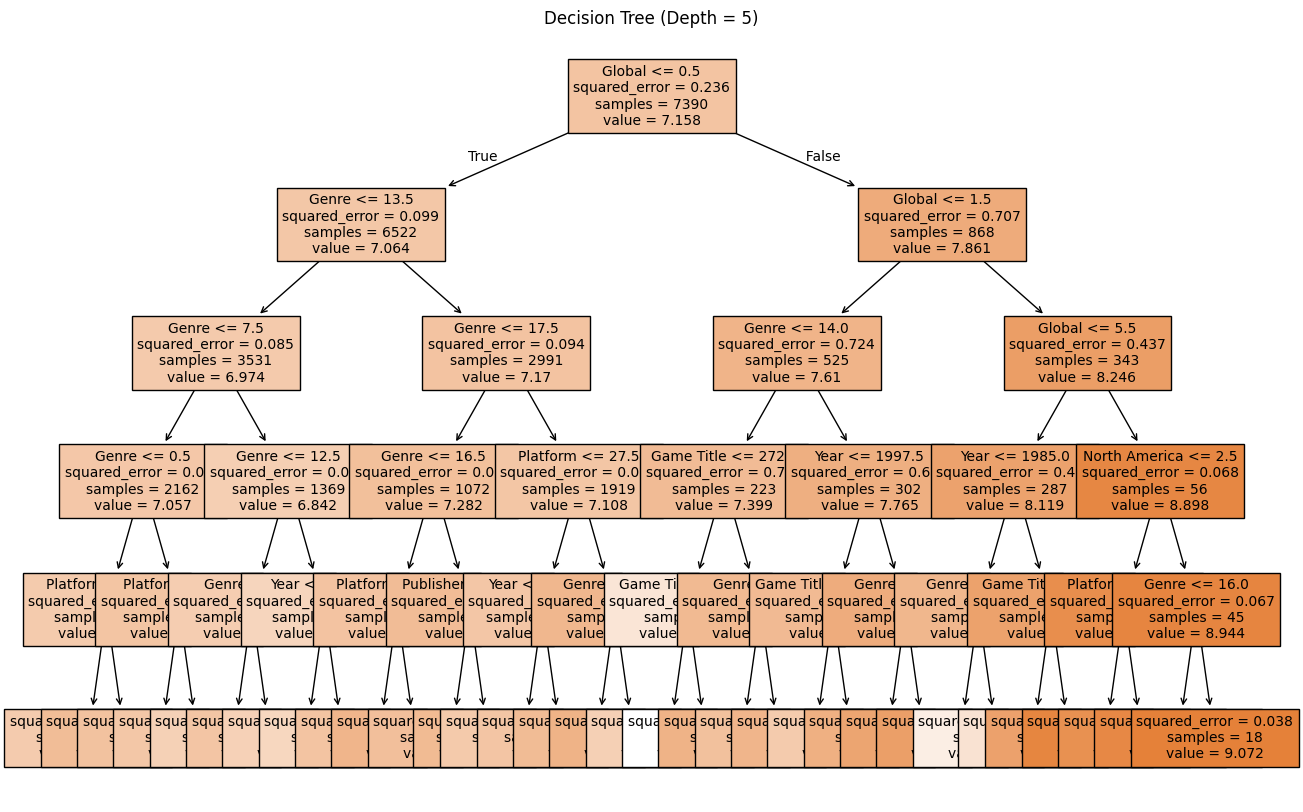

Missing values after cleaning:
id                   0
Game Title           0
Year                 0
Publisher            0
North America        0
Europe               0
Japan                0
Rest of World        0
Global               0
Number of Reviews    0
Wishlist             0
Platform             0
Genre                0
dtype: int64


In [12]:
def run_model_on_test(best_model, df_test):
    # Asegurarse de que los datos de prueba están preprocesados de la misma forma
    X_test = preprocess_data(df_test, is_train=False)
    
    # Realizar predicciones con el modelo entrenado
    predictions = best_model.predict(X_test)
    
    return predictions

workflow_results = run_decision_tree_workflow(df_train, df_test)
best_model = workflow_results["model"]  # Extrae el modelo desde los resultados de workflow
df_results = run_model_on_test(best_model, df_test)

submission = pd.DataFrame({
    'id': df_test['id'],  # Usar df_test para obtener los identificadores
    'Prediction': df_results
})

# Guardar el DataFrame como un archivo CSV
submission.to_csv('submission#2.csv', index=False)

In [ ]:
# Crear un DataFrame para las predicciones

#evaluar nuestro modelo con test


In [ ]:
from joblib import dump, load
dump(best_model, 'tree.joblib')


Importamos librerias

In [ ]:
from joblib import dump, load
dump(best_model, 'tree.joblib')

#model.load('tree.joblib')
#model.predict(X_test)
 #  Guardar el modelo en un archivo